In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
import json
import os
from pathlib import Path

In [14]:
#current_dir = os.path.dirname(os.path.abspath(__file__))
#project_root = os.path.dirname(current_dir)
#CONFIG_FILE_PATH = os.path.join(project_root, 'config', 'params.json')
CONFIG_FILE_PATH = os.path.join(os.path.dirname(os.getcwd()), 'config', 'params.json')

def load_config(file_path):
    with open(file_path, 'r') as f:
        config = json.load(f)
    return config

In [15]:
#if __name__ == "__main__":
#    params_config = load_config(CONFIG_FILE_PATH)
    # ... rest of your main script
params_config = load_config(CONFIG_FILE_PATH)

In [16]:
params_config

{'simulation': {'wavelength_mm': 0.0005,
  'Nx': 1024,
  'Ny': 1024,
  'Lx_mm': 20.0,
  'Ly_mm': 10.0,
  'z_prop_mm': 500.0},
 'slit': {'width_mm': 0.001, 'height_mm': 1.0},
 'plot_limits': {'initial_field_xlim_mm_zoom': 0.005,
  'initial_field_ylim_mm_zoom': 0.5,
  'diffraction_pattern_xlim_mm': 50.0}}

In [23]:
# --- 1. Simulation Parameters ---
wavelength = 500e-9  # Wavelength of light (e.g., 500 nm for green light)
k = 2 * np.pi / wavelength # Wavenumber

# Simulation grid size (number of pixels)
Nx = 1024
Ny = 1024

# Physical dimensions of the simulation space
Lx = 10e-3 # 10 mm
Ly = 10e-3 # 10 mm

# Spatial resolution (pixel size)
dx = Lx / Nx
dy = Ly / Ny


In [ ]:
# Propagation distance (distance from slit to screen)
z_prop = 0.5  # 0.5 meters (50 cm)

# --- Slit Parameters ---
slit_width = 100e-6  # 100 micrometers in the X direction
slit_height = 1e-3   # 1 mm (make it long to approximate 1D diffraction for clarity) in Y direction

In [14]:
x = np.linspace(-Lx / 2, Lx / 2, Nx)
y = np.linspace(-Ly / 2, Ly / 2, Ny)
X, Y = np.meshgrid(x, y) # 2D coordinate grids

In [15]:
# --- Initial Field (just after the slit) ---
# A plane wave with amplitude 1 passing through the slit
# Create the slit transmission function
slit_mask = np.zeros((Ny, Nx), dtype=complex) # Complex array for the field

# Define the slit boundaries in terms of array indices
# np.where returns tuples of (row_indices, col_indices)
y_slit_indices = np.where(np.abs(Y) <= slit_height / 2)[0]
x_slit_indices = np.where(np.abs(X) <= slit_width / 2)[1]

# Set the amplitude to 1 within the slit region
# Using boolean indexing for clarity and safety
slit_mask[(np.abs(Y) <= slit_height / 2) & (np.abs(X) <= slit_width / 2)] = 1.0

# The initial field U0 is the incident plane wave (amplitude 1) multiplied by the slit mask
U0 = slit_mask

In [16]:
# --- 2. Compute Angular Spectrum (FFT) ---
# The FFT naturally puts the zero-frequency component at (0,0) (top-left).
# We use fftshift to move it to the center for easier interpretation and
# correct calculation of kx, ky.
A0 = fftshift(fft2(U0))

In [17]:
# --- 3. Define Frequency Grids ---
# Spatial frequencies (k-space)
# Need to define these carefully based on our spatial grid size and resolution.
# The frequency ranges go from -pi/dx to pi/dx
kx = 2 * np.pi * np.fft.fftfreq(Nx, d=dx)
ky = 2 * np.pi * np.fft.fftfreq(Ny, d=dy)

# Create 2D frequency grids
KX, KY = np.meshgrid(fftshift(kx), fftshift(ky)) # fftshift to match A0's center

In [18]:
# --- 4. Define Propagation Transfer Function (H) ---
# This is the "propagator" in the frequency domain
# H(kx, ky, z) = exp(i * kz * z) where kz = sqrt(k^2 - kx^2 - ky^2)

# Calculate kz. Handle evanescent waves (imaginary kz) by setting their amplitude to 0.
# We use np.sqrt(k**2 - KX**2 - KY**2 + 0j) to ensure complex result even if argument is negative
KZ = np.sqrt(k**2 - KX**2 - KY**2 + 0j) # +0j ensures complex output for sqrt

# Create the transfer function
H = np.exp(1j * KZ * z_prop)

In [19]:
# --- 5. Propagate Angular Spectrum ---
A_prop = A0 * H

In [20]:
# --- 6. Reconstruct Field at Observation Plane (Inverse FFT) ---
# Use ifftshift to undo the fftshift from earlier, so ifft2 works correctly.
U_prop = ifft2(ifftshift(A_prop))

In [21]:
# --- 7. Calculate Intensity ---
# Intensity is proportional to the squared magnitude of the electric field
Intensity = np.abs(U_prop)**2

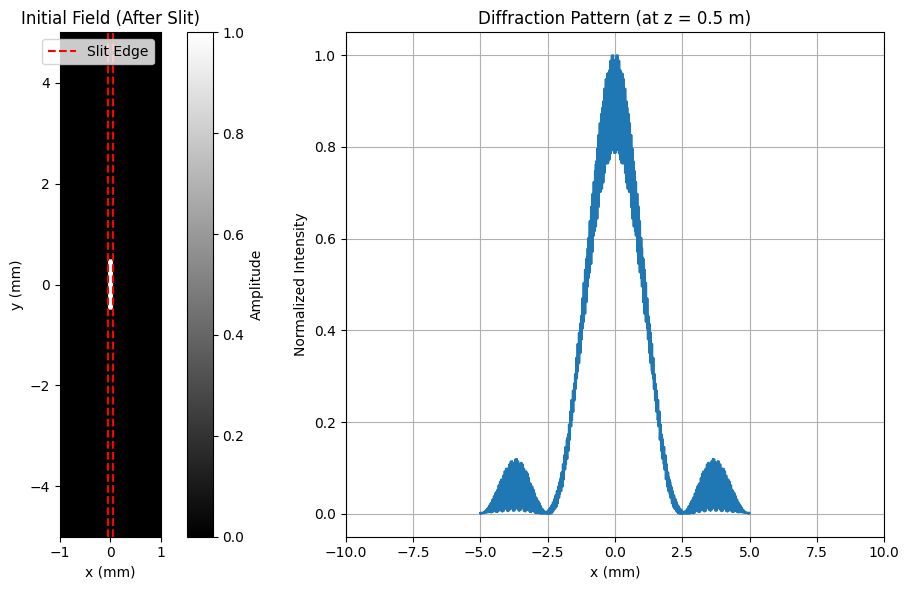

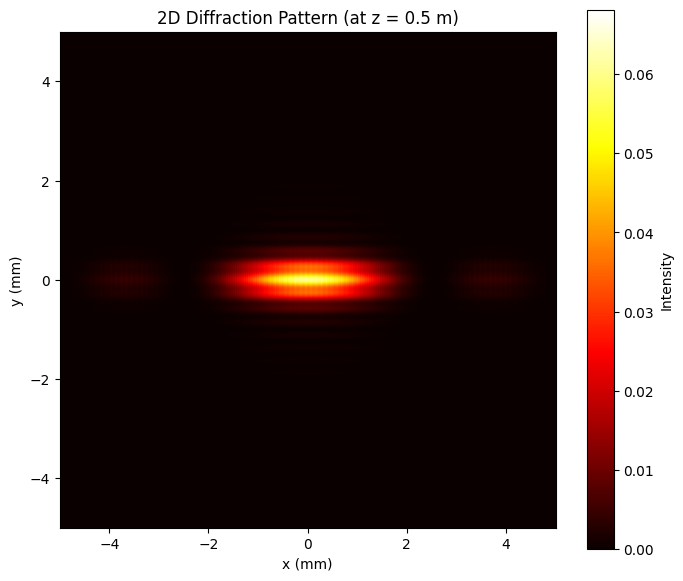

In [24]:
# --- 8. Visualization ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(np.abs(U0), cmap='gray', extent=[x.min()*1e3, x.max()*1e3, y.min()*1e3, y.max()*1e3], origin='lower')
plt.title('Initial Field (After Slit)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.colorbar(label='Amplitude')
plt.axvline(x=-slit_width/2 * 1e3, color='red', linestyle='--', label='Slit Edge')
plt.axvline(x=slit_width/2 * 1e3, color='red', linestyle='--')
plt.legend()
plt.xlim([-slit_height/2 * 1e3 - 0.5, slit_height/2 * 1e3 + 0.5]) # Zoom in on the slit region


plt.subplot(1, 2, 2)
# We often just look at a slice of the intensity pattern for 1D diffraction
# Take a slice through the center of the y-axis
center_y_index = Ny // 2
intensity_slice = Intensity[center_y_index, :]

plt.plot(x * 1e3, intensity_slice / intensity_slice.max()) # Normalize to 1 for plotting
plt.title(f'Diffraction Pattern (at z = {z_prop} m)')
plt.xlabel('x (mm)')
plt.ylabel('Normalized Intensity')
plt.grid(True)
plt.xlim([-10, 10]) # Adjust this to see the pattern clearly, depends on z_prop and slit_width

plt.tight_layout()
plt.show()

# You can also show the 2D intensity pattern if you wish
plt.figure(figsize=(8, 7))
plt.imshow(Intensity, cmap='hot', extent=[x.min()*1e3, x.max()*1e3, y.min()*1e3, y.max()*1e3], origin='lower')
plt.title(f'2D Diffraction Pattern (at z = {z_prop} m)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.colorbar(label='Intensity')
plt.show()